In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
# sma function
def SMA(data, period=30, column='close'):
    return data[column].rolling(window=period).mean()
    

# create function to signal when to buy and sell an asset
def SMACrossoverSignals(data, SMA1, SMA2, column='close'):
    buyList = []
    sellList = []
    flag = -1
    for i in range(0, len(data)):
        if SMA1[i] > SMA2[i]:
            sellList.append(np.nan)
            if flag != 1:
                buyList.append(data[column][i])
                flag = 1
            else:
                buyList.append(np.nan)
        elif SMA1[i] < SMA2[i]:
            buyList.append(np.nan)
            if flag != 0:
                sellList.append(data[column][i])
                flag = 0
            else:
                sellList.append(np.nan)
        else:
            buyList.append(np.nan)
            sellList.append(np.nan)
    return [buyList, sellList]
def get_pips(data, TAKE_PROFIT = 0.2, STOP_LOSS = 0.2): 
    # Pre-allocate memory for the profit_loss array
    profit_loss = np.zeros(data.shape[0])
    
    # Find the indices where the buy signal and take profit conditions are met
    buy_indices = np.where(data['Buy_Signal_Price'] > 0)[0]
    tp_indices = np.where(data['Buy_Signal_Price'] + TAKE_PROFIT <= data['close'])[0]
    # Calculate the profit_loss at the take profit indices
    profit_loss[tp_indices] = TAKE_PROFIT
    
    # Find the indices where the buy signal and stop loss conditions are met
    sl_indices = np.where(data['Buy_Signal_Price'] - STOP_LOSS >= data['close'])[0]
    
    # Calculate the profit_loss at the stop loss indices
    profit_loss[sl_indices] = -STOP_LOSS
    
    # Calculate the total profit_loss
    total_profit_loss = profit_loss.sum()
    
    # get an index of the winning trades
    win_trades_index = np.where(profit_loss > 0)[0]
    # get an index of the losing trades
    loss_trades_index = np.where(profit_loss < 0)[0]    
    # print([total_profit_loss, len(win_trades_index), len(loss_trades_index)])
    # make array of return values with total profit, number of winning trades, and number of trades
    return [round(total_profit_loss,2), len(win_trades_index), len(loss_trades_index)]

def StopLossOptimization(train, take_profit_range, stop_loss_range):
    # Use NumPy's meshgrid function to generate all combinations of take profit and stop loss values
    take_profit_values, stop_loss_values = np.meshgrid(take_profit_range, stop_loss_range)

    # Flatten the arrays to 1D arrays
    take_profit_values = take_profit_values.flatten()
    stop_loss_values = stop_loss_values.flatten()

    # Create a DataFrame with the take profit and stop loss values
    df = pd.DataFrame({'take_profit': take_profit_values.round(2), 'stop_loss': stop_loss_values.round(2)})

    # Use the apply method to calculate the pips and trade win rate for each combination of take profit and stop loss
    vals = df.apply(lambda row: get_pips(train, TAKE_PROFIT=row['take_profit'], STOP_LOSS=row['stop_loss']), axis=1)
    df["pips"] = vals.apply(lambda x: x[0])
    df["wins"] = vals.apply(lambda x: x[1])
    df["losses"] = vals.apply(lambda x: x[2])

    # Pivot the DataFrame to create the final table
    matrix = df.pivot(index='stop_loss', columns='take_profit', values='pips')
    return matrix, df

In [3]:
# get github txt file url
url = 'https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/MES%2006-21.Last.txt'
# read git hub txt file
MES = pd.read_csv(url, names=['time', 'open', 'high', 'low', 'close', 'volume'], delimiter = ";",)

train = MES.copy()[40000:].reset_index(drop=True)
test = MES.copy()[:40000].reset_index(drop=True)

sma1 = SMA(train, period=21, column='close').to_frame()
sma2 = SMA(train, period=50, column='close').to_frame()

In [4]:
# store the buy and sell data into a variable
train['Buy_Signal_Price'], train['Sell_Signal_Price'] = SMACrossoverSignals(train, sma1.close, sma2.close, column='close')
train['Buy_Signal_Price'] = train['Buy_Signal_Price'].shift(1)
train['Sell_Signal_Price'] = train['Sell_Signal_Price'].shift(1)

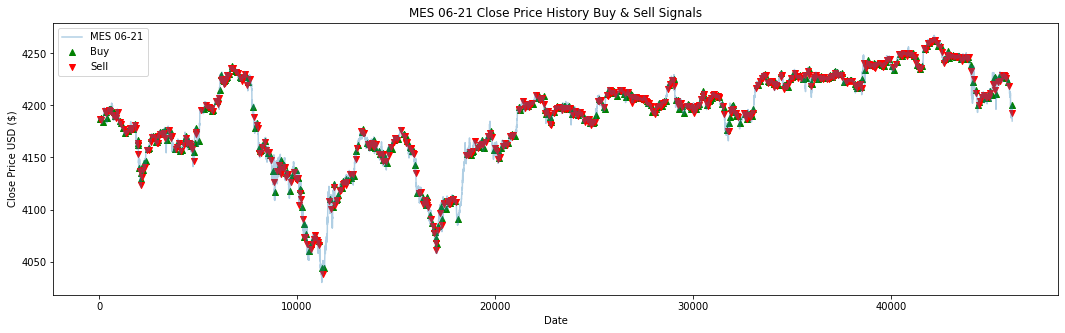

In [5]:
# visualize the data and the strategy to buy and sell MES
plt.figure (figsize=(18, 5))
plt.plot(train.index, train['close'], label = 'MES 06-21', alpha = 0.35)
# plt.plot(sma1.index, sma1.close.ravel(), label = 'sma21', alpha = 0.25)
# plt.plot(sma2.index, sma2.close.ravel(), label = 'sma50', alpha = 0.25)
plt.scatter(train.index, train['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(train.index, train['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('MES 06-21 Close Price History Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()


In [6]:
# Set the range of values for the take profit and stop loss
take_profit_range = np.arange(0.1, 3.1, 0.1)
stop_loss_range = np.arange(0.1, 3.1, 0.1)

# Call the StopLossOptimization function to get the matrix
matrix, df= StopLossOptimization(train, take_profit_range, stop_loss_range)


# get the row with the maximum pips
max_row = df.loc[df['pips'].idxmax()]

print("Take profit: ", max_row['take_profit'])
print("Stop loss: ", max_row['stop_loss'])
print("Maximum pips: ", max_row['pips'])
print("")
print("Wins: ", max_row['wins'])
print("Losses: ", max_row['losses'])


Take profit:  0.5
Stop loss:  2.8
Maximum pips:  42.5

Wins:  113.0
Losses:  5.0


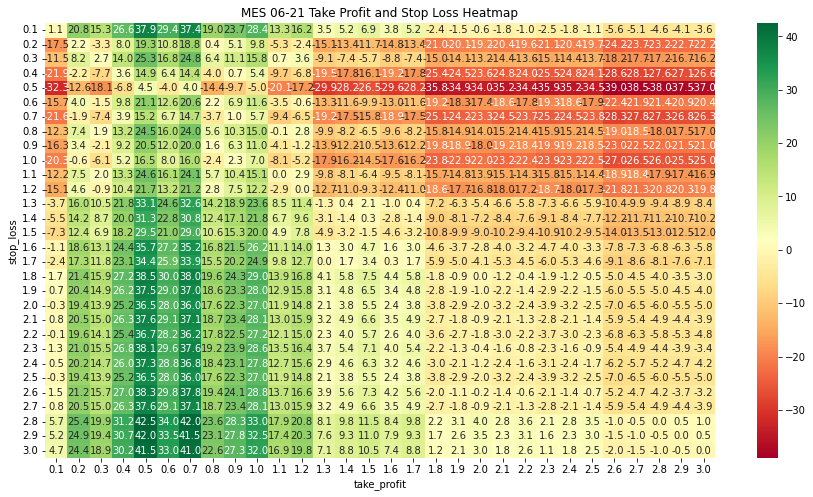

In [7]:
# plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matrix, annot=True, fmt='.1f', cmap='RdYlGn')
plt.title('MES 06-21 Take Profit and Stop Loss Heatmap')
plt.show()

In [8]:
# sort df by pips
df_sort = df.sort_values(by=['pips'], ascending=False).reset_index(drop=True)
display(df_sort.head(10))

,take_profit,stop_loss,pips,wins,losses
0,0.5,2.8,42.5,113,5
1,0.7,2.8,42.0,80,5
2,0.5,2.9,42.0,113,5
3,0.7,2.9,41.5,80,5
4,0.5,3.0,41.5,113,5
5,0.7,3.0,41.0,80,5
6,0.5,1.8,38.5,113,10
7,0.5,2.6,38.3,113,7
8,0.5,2.3,38.1,113,8
9,0.7,1.8,38.0,80,10


TODO: Find better sma value